# DataLoading

In [ ]:
import torch 
import numpy as np

In [ ]:
!git clone https://github.com/XL2248/MSCTD

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 20.73 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Checking out files: 100% (934/934), done.


In [ ]:
!ls

drive  MSCTD  sample_data


In [ ]:
!cp MSCTD/MSCTD_data/ende/english_*.txt .
!cp MSCTD/MSCTD_data/ende/image_index_*.txt .
!cp MSCTD/MSCTD_data/ende/sentiment_*.txt .

In [ ]:
!cp drive/MyDrive/train_ende.zip .
!cp drive/MyDrive/test.zip .
!cp drive/MyDrive/dev.zip .

In [ ]:
!ls

dev.zip		   image_index_dev.txt	  sentiment_dev.txt
drive		   image_index_test.txt   sentiment_test.txt
english_dev.txt    image_index_train.txt  sentiment_train.txt
english_test.txt   MSCTD		  test.zip
english_train.txt  sample_data		  train_ende.zip


In [ ]:
%%bash
for x in *.zip
do
  unzip -qq $x
done;

In [ ]:
!ls train_ende/ -l | wc -l 

20241


In [ ]:
import PIL
import os

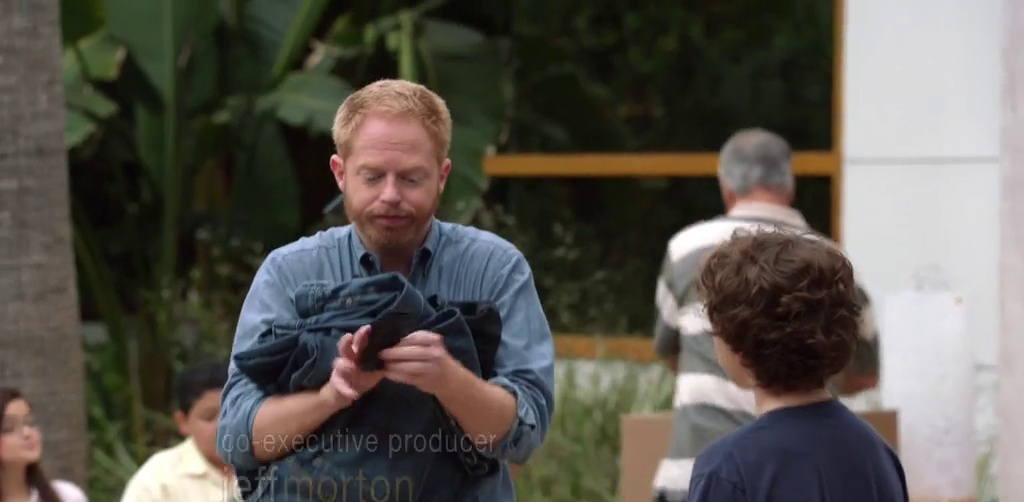

In [ ]:
image = PIL.Image.open(os.path.join("train_ende", "20239.jpg"))
display(image)

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Dataset

In [ ]:
# -*-coding:UTF-8-*-
from __future__ import division
import torch
import random
import numpy as np
import numbers
import collections
import cv2

def normalize(tensor, mean, std):

    """Normalize a ``torch.tensor``

    Args:
        tensor (torch.tensor): tensor to be normalized.
        mean: (list): the mean of BGR
        std: (list): the std of BGR
    
    Returns:
        Tensor: Normalized tensor.
    """
    # (Mytransforms.to_tensor(img), [128.0, 128.0, 128.0], [256.0, 256.0, 256.0]) mean, std

    for t, m, s in zip(tensor, mean, std):
        t.sub_(m).div_(s)
    return tensor

def to_tensor(pic):
    """Convert a ``numpy.ndarray`` to tensor.

    h , w , c -> c, h, w

    See ``ToTensor`` for more details.

    Args:
        pic (numpy.ndarray): Image to be converted to tensor.

    Returns:
        Tensor: Converted image.
    """

    img = torch.from_numpy(pic.transpose((2, 0, 1)))

    return img.float()
class toTensor(object):
    def __init__(self) :
        pass
    def __call__(self,img):
        return to_tensor(img)
    

class Compose(object):
    """Composes several transforms together.

    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.

    Example:
        >>> Mytransforms.Compose([
        >>>      Mytransforms.RandomResized(),
        >>>      Mytransforms.RandomRotate(40),
        >>>      Mytransforms.RandomCrop(368),
        >>>      Mytransforms.RandomHorizontalFlip(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):

        for t in self.transforms:
            img=t(img)
            

        return img


In [ ]:
import os
import scipy.io
import numpy as np
import glob
import torch.utils.data as data
import scipy.misc
from PIL import Image
import cv2
# import Mytransforms
from math import ceil
def read_data_file(root_dir):
    """get train or val images
        return: image list: train or val images list
    """
    image_arr = np.array(glob.glob(os.path.join(root_dir, '*.jpg')))
    image_nums_arr = np.array([int(s.rsplit('/')[-1][0:-4]) for s in image_arr])
    sorted_image_arr = image_arr[np.argsort(image_nums_arr)]
    return sorted_image_arr.tolist()

def read_index_file(root_dir):
    f = open(root_dir, "r")
    L=f.read().splitlines()
    f.close()
    return list(map(lambda x:list(map(int, x[1:-1].split(','))),L))

def read_text_file(root_dir):
    f = open(root_dir, "r")
    L= f.read().splitlines()
    f.close()
    return L
    
def read_sentiment_text(root_dir):
    f = open(root_dir, "r")
    L=f.read().splitlines()
    f.close()
    return L

class MSCTD(data.Dataset):
    def __init__(self,mode='train', root_dir="/content", transformer=None,read_mode='scene'):
        """
            mode : Enter type of dataset train , dev , test
            root_dir : Just Enter path of Dataset files 
            transformer : expand dataset.
            read_mode : scene or signle
        """
        self.transformer = transformer
        self.read_mode=read_mode
        self.root_dir = root_dir
        if mode=="train":
          self.img_list=read_data_file(root_dir+"//"+"train_ende")
        else :
          self.img_list=read_data_file(root_dir+"//"+mode)

        self.image_index=read_index_file(root_dir+"//"+"image_index_"+mode+".txt")
        self.english_text=read_text_file(root_dir+"//"+"english_"+mode+".txt")
        self.sentiment=read_sentiment_text(root_dir+"//"+"sentiment_"+mode+".txt")
        
    def __getitem__(self, index):
        
        if self.read_mode == "scene":
            img = []
            text = []
            sentiment = []
            img_index = self.image_index[index]
            for i in img_index:
                img.append(self.transformer(np.array(cv2.imread(self.img_list[i]), dtype=np.float32)))
                text.append(self.english_text[i])
                sentiment.append(self.sentiment[i])
            
            return (img,text,sentiment,index)

        elif self.read_mode == "single":

            img = []
            text = []
            sentiment = []
            
            img.append(self.transformer(np.array(cv2.imread(self.img_list[index]), dtype=np.float32)))
            text.append(self.english_text[index])
            sentiment.append(self.sentiment[index])
            
            return (img,text,sentiment,index)

    def __len__(self):
        if self.read_mode == "scene":
            return len(self.image_index)
        elif self.read_mode == "single":
            return len(self.img_list)
        

# DataLoader

In [ ]:
training_data=MSCTD(mode='train',root_dir="/content",transformer=Compose([toTensor(),]),read_mode="scene")
valid_data=MSCTD(mode='dev',root_dir="/content",transformer=Compose([toTensor(),]),read_mode="scene")
test_data=MSCTD(mode='test',root_dir="/content",transformer=Compose([toTensor(),]),read_mode="scene")

In [ ]:
# type(training_data[0])

In [ ]:
from torch.utils.data import DataLoader
batchSize = 1
train_loader = DataLoader(training_data, batch_size=batchSize, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batchSize, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batchSize, shuffle=False)

In [ ]:
def sentiment(loader):
    x = []
    for batch, (img,text,sentiment,Z) in enumerate(loader):
      print(batch)
      for i in sentiment:
        x.extend(i[0])

    return x

In [ ]:
next(iter(train_loader))[2]

[('0',), ('0',), ('1',), ('1',), ('1',)]

In [ ]:
h = sentiment(train_loader)

In [ ]:
x = []
for j in training_data:
  for i in j[2]:
    x.extend(i[0])

In [ ]:
len(x)

20240

In [ ]:
import seaborn as s

In [ ]:
s.hist(x,)